In [1]:
import numpy as np
import pandas as pd

def generate_staggered_law_ar1_data_power(N, T, rho, num_individuals, mean=0, std_dev=1):
    # Generate random white noise for each individual
    white_noise = np.random.normal(mean, std_dev, size=(N, num_individuals, T))

    # Initialize the array to store the data
    data = np.zeros((N, num_individuals, T))

    # Generate the AR(1) process data for each individual
    for i in range(N):
        for j in range(num_individuals):
            for t in range(T):
                if t == 0:
                    data[i, j, t] = white_noise[i, j, t]
                else:
                    data[i, j, t] = rho * data[i, j, t - 1] + white_noise[i, j, t]

    # Reshape the data array for easier DataFrame creation
    reshaped_data = data.reshape((N * num_individuals, T))

    # Create a DataFrame with column names as time periods
    df = pd.DataFrame(reshaped_data, columns=[f'{t}' for t in range(T)])

    # Add a new 'state' column with repeated state values
    df['state'] = np.repeat(np.arange(1, N + 1), num_individuals)

    # Add a new 'individual' column with repeated individual values
    df['individual'] = np.tile(np.arange(1, num_individuals + 1), N)

    melted_df = pd.melt(df, id_vars=['state', 'individual'], var_name='time', value_name='value')

    # Convert the 'time' column to int
    melted_df['time'] = melted_df['time'].astype(int)

    data = melted_df.copy()

    data['time'] = data['time'].astype(int)
    # Create state dummy variables
    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)

    # Convert state dummy variables to int
    state_dummies = state_dummies.astype(int)

    # Create time dummy variables
    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True)

    # Convert time dummy variables to int
    time_dummies = time_dummies.astype(int)

    data = pd.concat([data, state_dummies, time_dummies], axis=1)

    return data


Number of times null hypothesis is rejected : 0 out of 50 simulations
Power of the test: 0.0 %
Bias for Coefficient of Treatment (True Value = 0.02): -0.02
MSE for Coefficient of Treatment (True Value = 0.02): 0.0004


c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


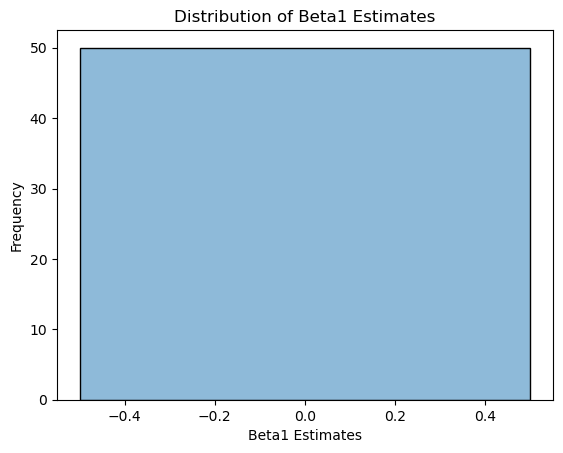

In [2]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
rho = 0.8

bias_values = []

N = 50
T = 20
true_beta1_value = 0.02 
squared_error_values = []
standard_error_values =[]
num_simulations = 50


for _ in range(num_simulations):
    data = generate_staggered_law_ar1_data_power(N, T, rho, num_individuals= 10)
    
    states = data['state'].unique()
    

    # Randomly select half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)
    
    data['outcome'] = data.apply(lambda x: x['value']*(1.02) if x['TREATMENT'] == 1 else x['value'], axis=1)
       

    cps_agg = data.groupby(['state', 'time'])[['outcome', 'TREATMENT']].mean().reset_index()

    # One-hot encode STATEFIP and YEAR
    dummy_df_state = pd.get_dummies(cps_agg['state'], prefix='state', drop_first=True)
    dummy_df_year = pd.get_dummies(cps_agg['time'], prefix='time', drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)

    # Convert True and False to 1 and 0 in the specified columns
    boolean_columns = ['state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']

    cps_agg[boolean_columns] = cps_agg[boolean_columns].astype(int)

    data = cps_agg.copy()

    X = data[[
       'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19' ]] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['outcome'] # Replace 'outcome' with your dependent variable
    
    model = sm.OLS(Y, X).fit()

    y_pred = model.predict(X)

    residuals = Y - y_pred

    data['Residuals'] = residuals

    a = state_to_treatment_year.keys()

    filtered_df = data[data['state'].isin(a)]
    

    # Separate pre-treatment and post-treatment data
    pre_treatment_df = filtered_df[filtered_df['TREATMENT'] == 0]
    post_treatment_df = filtered_df[filtered_df['TREATMENT'] == 1]

    # Calculate the average residuals for pre-treatment and post-treatment periods
    avg_residuals_pre_treatment = pre_treatment_df.groupby('state')['Residuals'].mean().reset_index()
    avg_residuals_post_treatment = post_treatment_df.groupby('state')['Residuals'].mean().reset_index()

    # Add a 'Treatment' column to indicate the treatment status for each period
    avg_residuals_pre_treatment['TREATMENT'] = 0
    avg_residuals_post_treatment['TREATMENT'] = 1

    # Combine the two DataFrames into a new DataFrame
    two_period_panel_df = pd.concat([avg_residuals_pre_treatment, avg_residuals_post_treatment], ignore_index=True)
    

    y = two_period_panel_df['Residuals']
    X = two_period_panel_df[['TREATMENT']]
    
    # Add a constant term (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)


average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)


# Print the number of rejections
print(f"Number of times null hypothesis is rejected : {reject_count} out of {num_simulations} simulations")
print(f"Power of the test: {type1_error * 100} %")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()



